In [ ]:
!pip install NewsSentiment
#https://huggingface.co/fhamborg/roberta-targeted-sentiment-classification-newsarticles


In [ ]:
from NewsSentiment import TargetSentimentClassifier
import pandas as pd
import numpy as np
from spacy.lang.en import English
import re
from scipy.special import softmax

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NLP2024/project/full_dataset.csv")

## Splitting documents into their sentences

In [ ]:
nlp = English()
nlp.add_pipe("sentencizer")

In [ ]:
docs = df["document"].values

In [ ]:
df["split_doc"] = df["document"].apply(lambda x: list(nlp(x).sents))

In [ ]:
df["split_doc"] = df["split_doc"].apply(lambda x: [str(y) for y in x])

### Subsetting all days that contain information about Israel (topic of focus)

In [ ]:
israel_subset = df[df["document"].apply([lambda x: True if re.findall("[iI]srael", x) else False]).values]

### Subsetting only relevant sentences & obtaining data to perform sentiment on by source type

In [ ]:
# From the list of all sentences, find those that discuss with Israel only
def subset_sentences(sent_list):
  return_list = []
  for sent in sent_list:
    if re.findall("[iI]srael", sent):
      return_list.append(sent)
  return return_list

In [ ]:
israel_subset["split_doc"] = israel_subset["split_doc"].apply(subset_sentences)

<ipython-input-425-6752f2b31f55>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
wsj_sent = israel_subset[israel_subset["source"] == "WSJ"]

In [ ]:
npr_sent = israel_subset[israel_subset["source"] == "NPR"]

In [ ]:
reuters_sent = israel_subset[israel_subset["source"] == "REUTERS"]

In [ ]:
fox_sent = israel_subset[israel_subset["source"] == "FOX"]

## Performing sentiment analysis

In [ ]:
tsc = TargetSentimentClassifier()

In [ ]:
# Example of the TargetSentimentClassifier from NewsSentiment
# L, M, R (M is topic)

In [ ]:
sentiment_array = []

for idx in range(len(israel_subset)):
  current_sentences = israel_subset.iloc[idx]["split_doc"]
  data = []
  for sent in current_sentences:
    matches = re.finditer("[Ii]srael", sent)
    for x in matches:
      idx_l = x.start()
      idx_r = x.end()
      ex_l = sent[:idx_l]
      ex_r = sent[idx_r:]
      ex_m = sent[idx_l:idx_r]
    data.append((ex_l, ex_m, ex_r))
  sentiments = tsc.infer(targets=data)
  sentiment_array.append(sentiments)



Processing batches: 100%|██████████| 4/4 [00:06<00:00,  1.63s/batch]


In [ ]:
# Aggregating means on a document level
arr_neg = []
arr_pos = []
arr_neut = []
for i in range(len(sentiment_array)):
  cur_neg = []
  cur_pos = []
  cur_neut = []
  for j in range(len(sentiment_array[i])):
    for idx in range(3):
      # The dictionary for sentiment is sorted in decreasing order
      cur_dict = sentiment_array[i][j][idx]
      if cur_dict['class_label'] == 'neutral':
        cur_neut.append(cur_dict['class_prob'])
      elif cur_dict['class_label'] == 'positive':
        cur_pos.append(cur_dict['class_prob'])
      else:
        cur_neg.append(cur_dict['class_prob'])

  arr_neg.append(np.mean(np.array(cur_neg)))
  arr_pos.append(np.mean(np.array(cur_pos)))
  arr_neut.append(np.mean(np.array(cur_neut)))


In [ ]:
israel_subset["negative_sentiment"] = arr_neg

<ipython-input-496-ef145d91adbe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
israel_subset["positive_sentiment"] = arr_pos

<ipython-input-497-e5772f636c9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
israel_subset["neutral_sentiment"] = arr_neut

<ipython-input-498-62e1aa58d9e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
from plotnine import *

## Visualizations

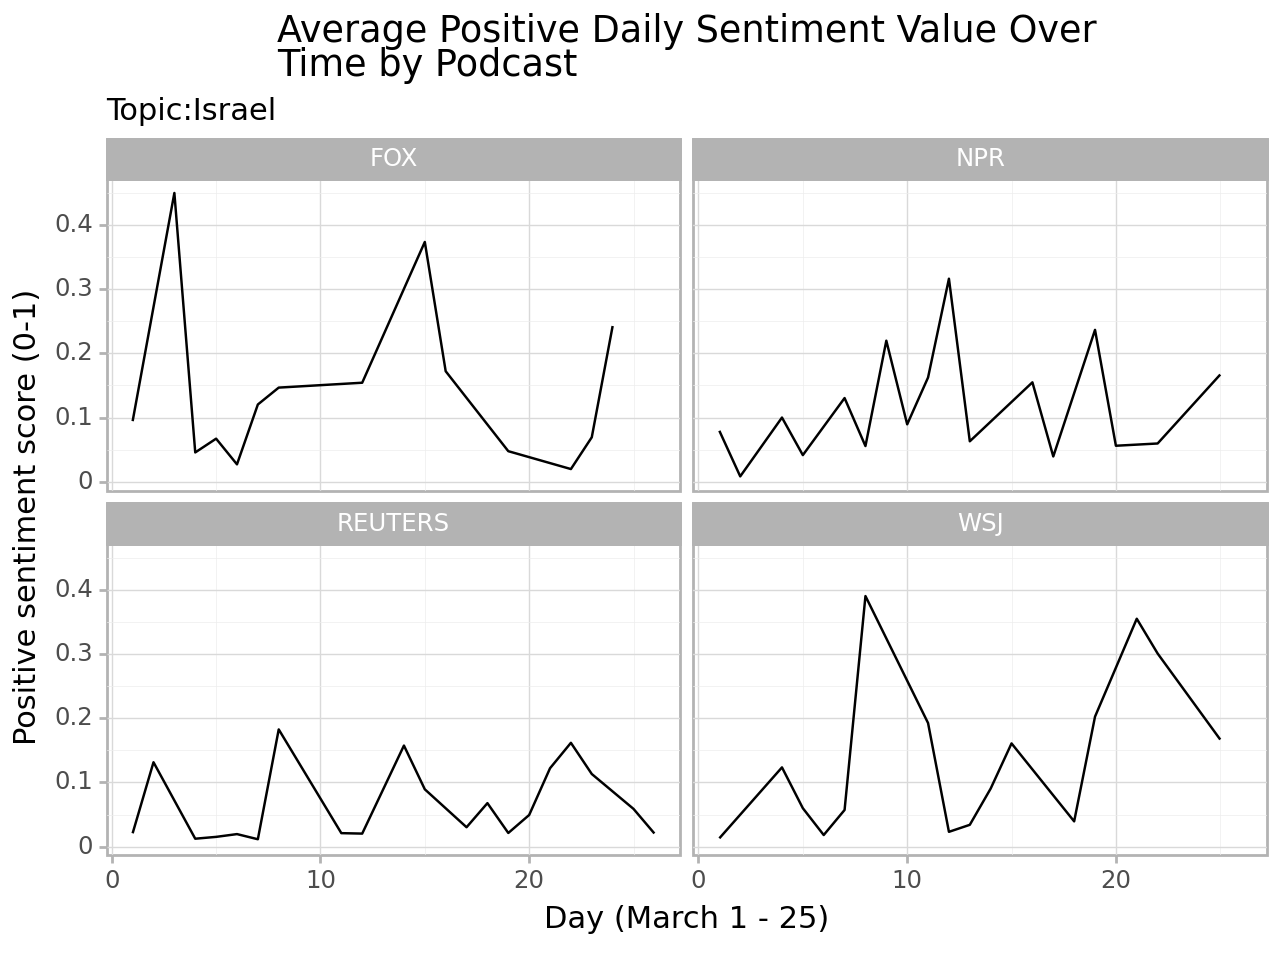

<Figure Size: (640 x 480)>

In [ ]:
e = ggplot(israel_subset, aes("day", "positive_sentiment"))
e + geom_line() + facet_wrap("source") + theme_light() + labs(title="Average Positive Daily Sentiment Value Over\nTime by Podcast",
                                                        x="Day (March 1 - 25)",
                                                        y="Positive sentiment score (0-1)", subtitle="Topic:Israel") + theme(plot_title=element_text(ha='center'))

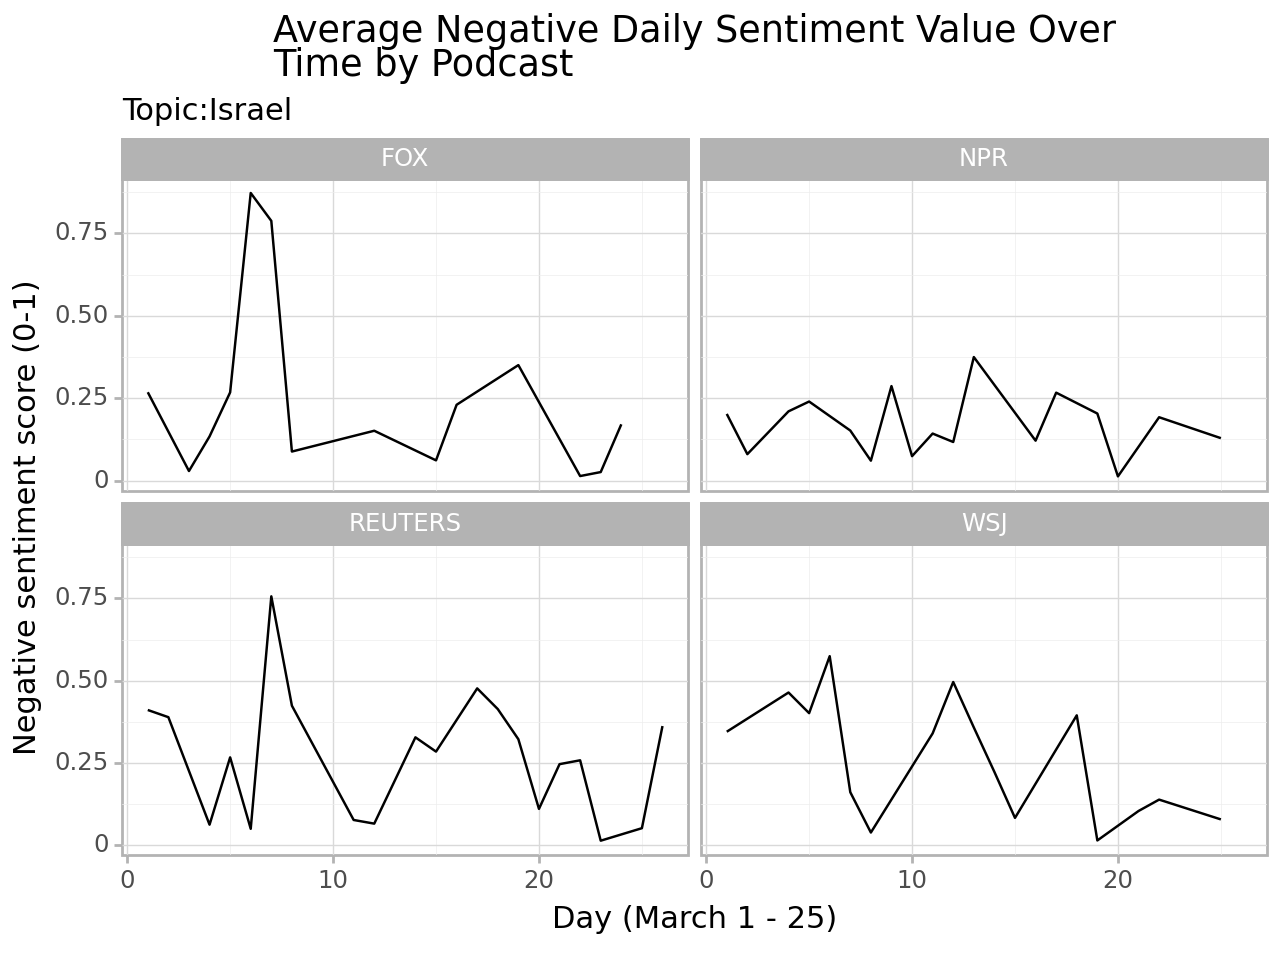

<Figure Size: (640 x 480)>

In [ ]:
e = ggplot(israel_subset, aes("day", "negative_sentiment"))
e + geom_line() + facet_wrap("source") + theme_light() + labs(title="Average Negative Daily Sentiment Value Over\nTime by Podcast",
                                                        x="Day (March 1 - 25)",
                                                        y="Negative sentiment score (0-1)", subtitle="Topic:Israel") + theme(plot_title=element_text(ha='center'))

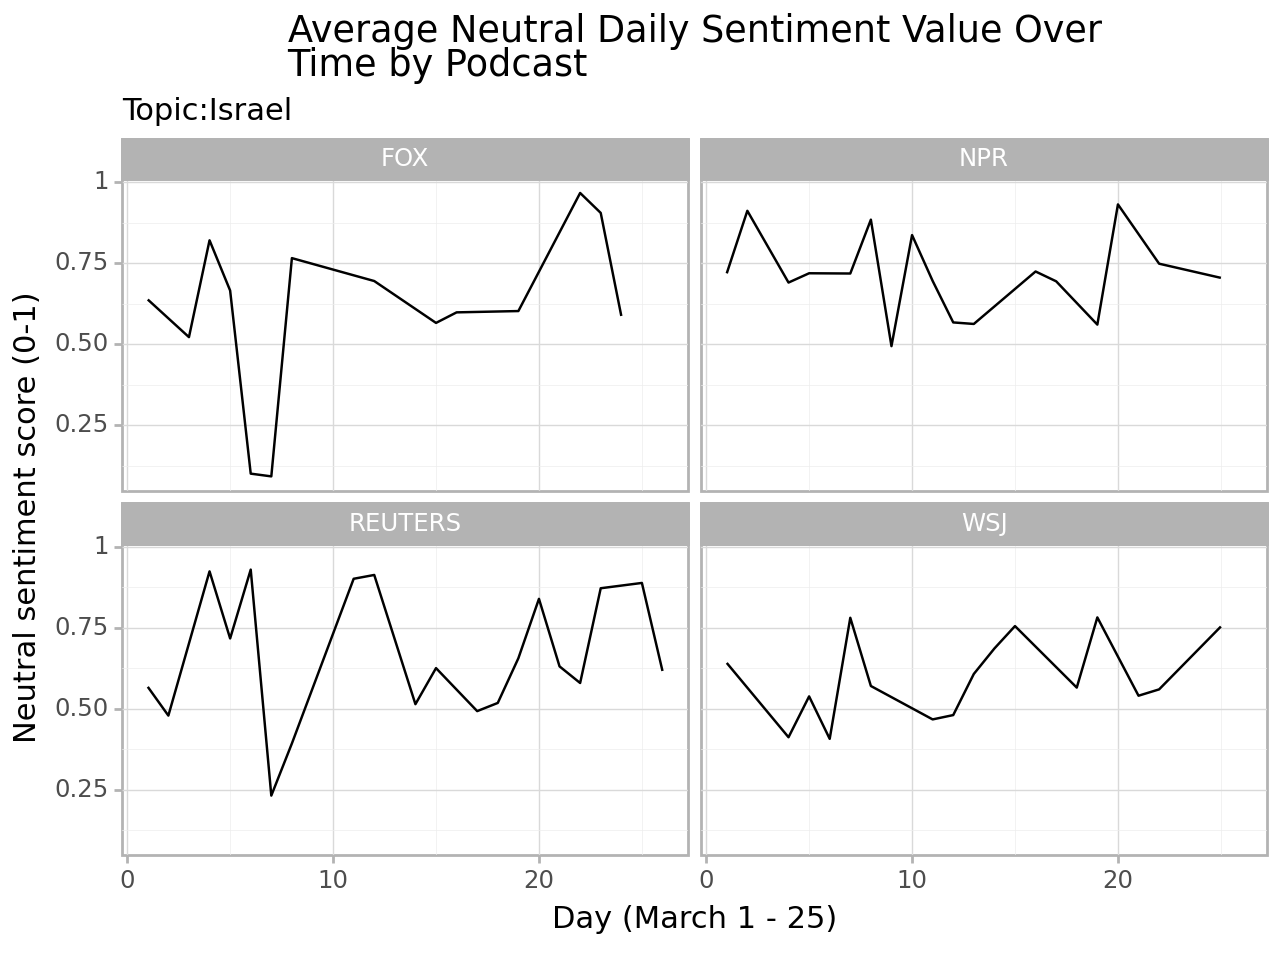

<Figure Size: (640 x 480)>

In [ ]:
e = ggplot(israel_subset, aes("day", "neutral_sentiment"))
e + geom_line() + facet_wrap("source") + theme_light() + labs(title="Average Neutral Daily Sentiment Value Over\nTime by Podcast",
                                                        x="Day (March 1 - 25)",
                                                        y="Neutral sentiment score (0-1)", subtitle="Topic:Israel") + theme(plot_title=element_text(ha='center'))

## Example of sentiment analysis on a sentence level


In [ ]:
ex = israel_subset.iloc[0]["split_doc"][0]


In [ ]:
ex

'President Biden says the U.S. will begin air-dropping humanitarian aid to Gaza in the next few days to help bring relief to Palestinians caught in the Israel-Hamas war.'

In [ ]:
matches = re.finditer("r'\b[Ii]sraeli?-?\b'", ex)
for m in matches:
  start = m.start()
  end = m.end()
  l = ex[:start]
  m = ex[start:end]
  r = ex[end:]

In [ ]:
(l,m,r)

('President Biden says the U.S. will begin air-dropping humanitarian aid to Gaza in the next few days to help bring relief to Palestinians caught in the ',
 'Israel',
 '-Hamas war.')

In [ ]:
sentiment = tsc.infer_from_text(l,m,r)

Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.48s/batch]


In [ ]:
sentiment

({'class_id': 0, 'class_label': 'negative', 'class_prob': 0.8928394913673401},
 {'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.09370338916778564},
 {'class_id': 2, 'class_label': 'positive', 'class_prob': 0.0134572209790349})